# Imports

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# import en_core_web_sm
nlp = spacy.load("en_core_web_sm")
# stopwords = nlp.Defaults.stop_words
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.decomposition import NMF
from sklearn import preprocessing
from nltk import ngrams
from nltk import FreqDist
from sklearn.decomposition import LatentDirichletAllocation as LDA
# nltk.download('all')

In [2]:
# charts
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [3]:
#warnings
import warnings
warnings.filterwarnings('ignore')

#options
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

# Functions

### 1. Data cleaning

In [4]:
def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # clean_text = re.sub('\S*\d\S*\s*', '', clean_text)
    
    return clean_text

def remove_punctuation(text):
    punctuation = text.translate(str.maketrans('', '', string.punctuation))
    return punctuation

def convert_to_lowercase(text):
    text_lower = text.lower()
    return text_lower

# def tokenization(text):
#     tokens  = word_tokenize(text)

#     return ' '.join(tokens)

def remove_stopwords(text):
    # stop_words = set(stopwords('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in STOP_WORDS]
    return ' '.join(filtered_words)
    

def lem_text(text):
    doc = nlp(text)
    lemma = ' '.join([token.lemma_ for token in doc])
    
    return lemma

def replace(text):
    replaced = text.replace('xxxx', '').replace('-PRON-', '')

    return replaced

# def spell_correct(text):
#     if text is None or not isinstance(text, str):
#         return text

#     spell = SpellChecker()

#     # Find misspelled words
#     misspelled = spell.unknown(text.split())

#     # Correct misspelled words
#     corrected_text = [spell.correction(word) if word in misspelled else word for word in text.split()]
    
#     try:
#         return ' '.join(corrected_text)
#     except:
#         return ' '.join(text)



### 2. Merge cleaning functions for one function

In [5]:
def preprocessing_data(text):
    
    text = remove_special_characters(text) #pass
    text = remove_punctuation(text) #pass
    text = convert_to_lowercase(text) #pass
    # text = tokenization(text) #pass
    text = remove_stopwords(text) #pass
    # text = lem_text(text) #pass
    text = replace(text) #pass
    return text

### 3. Restore basic forms of words

In [6]:
def lemmatization(text):
    doc = nlp(text)
    lem_tokens = [token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS]
    return ' '.join(lem_tokens)
    
    # return lem_text

def stemming(text):
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    stem_words = [stemmer.stem(word) for word in words if word.text.lower() not in STOP_WORDS]
    return ' '.join(stem_words)

    # return stem_text

def remove_POS_tags(text):
    doc = nlp(text)
    result = [token.text for token in doc if token.tag_ == 'NN']  # check for nouns
    return ' '.join(result)
    # return remove_pos


#Write your function to extract the POS tags NN
# def extract_pos_tags(text):
#     doc = nlp(text)
#     sent = [token.text for token in doc if token.tag_ == 'NN']
#     return ' '.join(sent)

# finding ngrams

In [7]:
def get_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return list(n_grams)

def get_top_ngrams(data, n, top=30):
    combined_text = ' '.join(data.astype(str))
    n_grams = get_ngrams(combined_text, n)
    freq_dist = FreqDist(n_grams)
    return freq_dist.most_common(top)

# Importing data 

### dataset - https://www.kaggle.com/datasets/abhishek14398/automatic-ticket-classification-dataset/data

In [8]:
path = "complaints.json"
open_path = open(path) 
read_data = json.load(open_path)
df=pd.json_normalize(read_data)

In [9]:
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product']]
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})

# data modelling
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)
df[df['complaint_text']==''] = np.nan
df = df[~df['complaint_text'].isnull()]

# text cleaning

In [10]:

data = df # replace to have possibility to load back original data
data['clean'] = data['complaint_text'].apply(lambda x: preprocessing_data(x)) # new column with preprocessed data
data['clean'] = data['clean'].apply(lambda x: lemmatization(x))
data['clean'] = data['clean'].apply(lambda x: remove_POS_tags(x))
data.head()

,complaint_text,category,clean
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt,morning help bank chase debt verification stat...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",book ticket come ticket reward card informatio...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account,son deposit chase account fund account pay mon...


### Check data

(array([9.006e+03, 6.382e+03, 2.804e+03, 1.296e+03, 7.970e+02, 3.180e+02,
        1.540e+02, 8.300e+01, 5.800e+01, 4.100e+01, 3.400e+01, 1.800e+01,
        1.500e+01, 1.100e+01, 1.200e+01, 5.000e+00, 5.000e+00, 5.000e+00,
        2.000e+00, 1.000e+00, 1.000e+01, 0.000e+00, 3.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([    0.  ,   248.32,   496.64,   744.96,   993.28,  1241.6 ,
         1489.92,  1738.24,  1986.56,  2234.88,  2483.2 ,  2731.52,
         2979.84,  3228.16,  3476.48,  3724.8 ,  3973.12,  4221.44,
         4469.76,  4718.08,  4966.4 ,  5214.72,  5463.04,  5711.36,
         5959.68,  6208.  ,  6456.32,  6704.64,  6952.96,  7201.28,
         7449.6 ,  7697.92,  7946.24

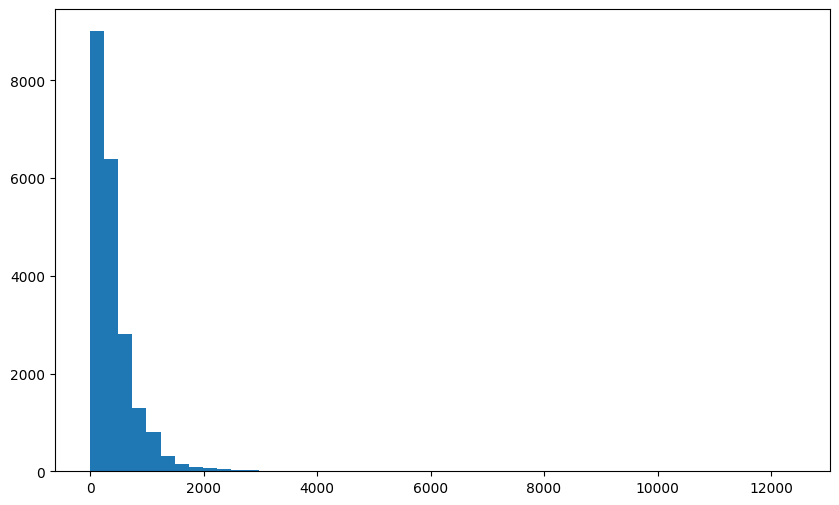

In [11]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
# doc_lens = [len(d) for d in data.clean]
doc_lens = [len(d) for d in data.clean]
plt.hist(doc_lens, bins = 50)

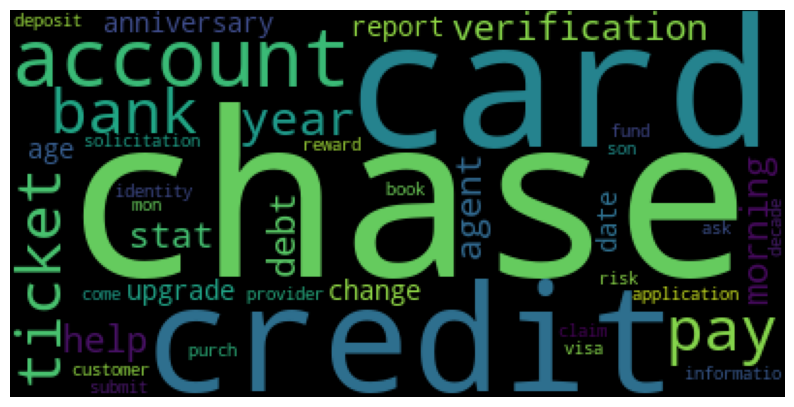

In [12]:

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(data['clean']))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Topic Modelling
### in this dataset I have too much categories, so my plan is to change quantity of categories to 5.
### This can be done by NFM or LDA
###
###
###

### Finding top n-grams

In [14]:
top_unigrams = get_top_ngrams(data['clean'], 1)
top_bigrams = get_top_ngrams(data['clean'], 2)
top_trigrams = get_top_ngrams(data['clean'], 3)

print("\n top unigrams : \n", top_unigrams[:5])
print("\n top top_bigrams : \n",top_bigrams[:5])
print("\n top top_trigrams : \n",top_trigrams[:5])


 top unigrams : 
 [(('chase',), 60157), (('account',), 43799), (('credit',), 33851), (('card',), 30211), (('payment',), 21160)]

 top top_bigrams : 
 [(('credit', 'card'), 12841), (('credit', 'report'), 3965), (('chase', 'credit'), 3433), (('call', 'chase'), 3349), (('check', 'account'), 3044)]

 top top_trigrams : 
 [(('chase', 'credit', 'card'), 2464), (('credit', 'card', 'account'), 1068), (('credit', 'card', 'company'), 981), (('credit', 'card', 'chase'), 813), (('chase', 'customer', 'service'), 586)]


### Vectorizer

In [17]:
model = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
dtm = model.fit_transform(data['clean']) # document term metrix
feature_names = np.array(model.get_feature_names_out())

In [18]:
# model = CountVectorizer(min_df=2, max_df=0.95, stop_words='english')
# dtm = model.fit_transform(data['clean']) # document term metrix
# feature_names = np.array(model.get_feature_names_out())

### NFM

In [82]:
# model = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
# dtm = model.fit_transform(data['clean']) # document term metrix
# feature_names = np.array(model.get_feature_names_out())

# model_nfm = NMF(n_components=5, random_state=40)
# W = model_nfm.fit_transform(dtm)
# H = model_nfm.n_components_

# categories = []
# for i, document in enumerate(dtm):
#     assigned_cat = W[i].argmax()
#     categories.append(assigned_cat)

# data["Dominant_Topic"] = categories

# num_words = 15
# for topic_idx, topic in enumerate(model_nfm.components_):
#     print(f"Topic #{topic_idx + 1}:")
#     top_words_idx = topic.argsort()[:-num_words - 1:-1]
#     top_words = [feature_names[i] for i in top_words_idx]
#     print(" ".join(top_words),"\n")


In [85]:
# skopiowane z neta, z jakiegoś powodu działa dużo lepiej

tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
dtm = tfidf.fit_transform(data['clean']) # document term metrix
# feature_names = np.array(model.get_feature_names_out())

num_topics =  5 

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_

num_words=15

vocab = np.array(tfidf.get_feature_names_out())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [86]:
vocab

array(['10day', '10pdf', '12th', ..., 'zombie', 'zone', 'zoom'],
      dtype=object)

In [87]:
topics

['account check bank money deposit chase fund branch day transfer number business transaction customer claim',
 'credit card report inquiry chase account score company information debt limit application reporting letter year',
 'loan mortgage chase home modification property year letter document rate foreclosure request time sale refinance',
 'charge card chase dispute fee transaction purchase merchant fraud claim service refund email time statement',
 'payment balance month pay fee statement day time chase auto date credit account year mortgage']

In [88]:
#Create the best topic for each complaint in terms of integer value 1,2,3,4

colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(data.clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)+ 1
df_doc_topic['Dominant_Topic'] = significant_topic
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Dominant_Topic
Doc0,0.02,0.01,0.03,0.01,0.01,3
Doc1,0.01,0.01,0.01,0.01,0.00,1
Doc2,0.00,0.05,0.00,0.00,0.00,2
Doc3,0.02,0.06,0.02,0.01,0.00,2
Doc4,0.07,0.00,0.00,0.00,0.00,1


In [89]:
data['Dominant_Topic'] = significant_topic

In [93]:
data.Dominant_Topic.value_counts()

Dominant_Topic
Banking and Account activities         5572
Credit Cards, Credit Reports           5011
Fees, Charges, and Account Balances    4771
Payments, Loans, and Mortgages         3715
Other                                  1997
Name: count, dtype: int64

In [84]:
# data[data['Dominant_Topic'] == 3].head(30)

In [91]:


#Create the dictionary of Topic names and Topics
topic_mapping = {
    1: 'Banking and Account activities',
    2: 'Fees, Charges, and Account Balances',
    3: 'Payments, Loans, and Mortgages',
    4: 'Credit Cards, Credit Reports',
    5: 'Other'
}

#Replace Topics with Topic Names
data['Dominant_Topic'] = data['Dominant_Topic'].map(topic_mapping)

data.to_csv('data.csv', index=False) # saving dataset

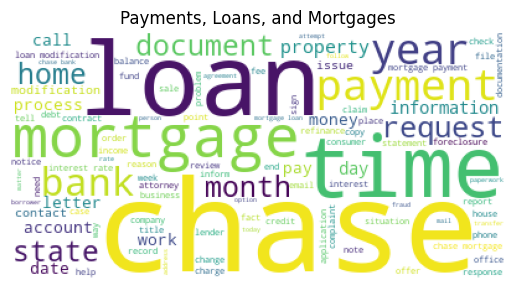

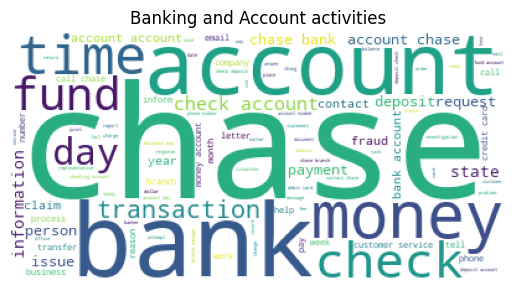

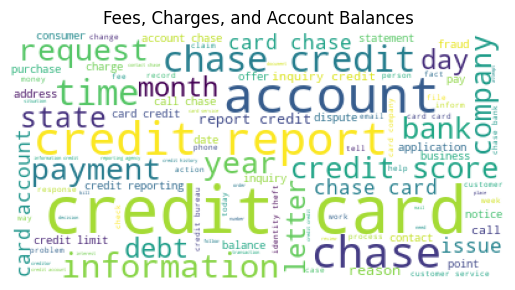

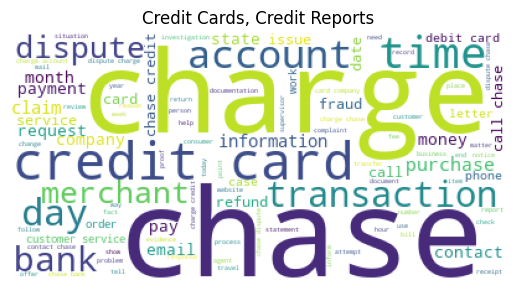

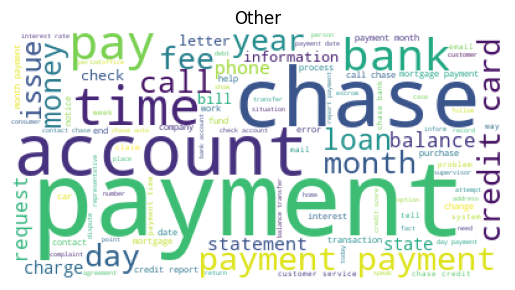

In [92]:
for x in data['Dominant_Topic'].unique():
	wc = WordCloud(background_color="white", max_words=100)
	wc.generate(data['clean'][(data['clean'].notnull()) & (data['Dominant_Topic'] == x)].to_string())
	plt.imshow(wc)
	plt.title(x)
	plt.axis("off")
	plt.show()

# wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(data['clean']))

# print(wordcloud)
# plt.figure(figsize=(10,6))
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show()

# importing dataset

In [95]:
data = pd.read_csv('data.csv')

# TESTING ON DIFFERENT CLASSIFICATORS

In [110]:
# training_data = data[['complaint_text','Dominant_Topic']]
training_data = data[['clean','Dominant_Topic']]
training_data.head()

,clean,Dominant_Topic
0,morning help bank chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help,"Payments, Loans, and Mortgages"
1,card agent upgrade anniversary date change agent information order upgrade account change anniversary date consent recording agent mislead,Banking and Account activities
2,chase card report application submit identity consent service credit verifying identity applicant,"Fees, Charges, and Account Balances"
3,book ticket come ticket reward card information minute notify screen decision refer bank chase bank notification screen representative speak application state information credit offer account statement purchase ticket account ask application representative application request proceed application chase fact credit account report credit report chase information credit report process application consent error,"Fees, Charges, and Account Balances"
4,son deposit chase account fund account pay money speek son money bank money son call chase time check owner country date check number claim number chase,Banking and Account activities


In [111]:
# x - y  split
# X = training_data.complaint_text
X = training_data.clean
y = training_data.Dominant_Topic

In [112]:
#Write your code to get the Vector count 

# Fit transform the X
count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

In [113]:
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code here to transform the word vector to tf-idf
#Fit transform word vector to TF-IDF
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)

In [114]:


from sklearn.model_selection import train_test_split
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=40, stratify=y)



In [115]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [116]:
# utlity function to display the model report

def display_classification_report(model,metric):
    
    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba,average='weighted',multi_class='ovr'),2)
    roc_auc_score_test = round(roc_auc_score(y_test, y_test_pred_proba,average='weighted',multi_class='ovr'),2)
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
    metric.append(roc_auc_score_train)
    metric.append(roc_auc_score_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
  
    precision_train,recall_train,fscore_train,support_train=precision_recall_fscore_support(y_train,y_train_pred,average='weighted')
    precision_test,recall_test,fscore_test,support_test=precision_recall_fscore_support(y_test,y_test_pred,average='weighted')
    
    acc_score_train = round(accuracy_score(y_train,y_train_pred),2)
    acc_score_test = round(accuracy_score(y_test,y_test_pred),2)
    
    metric.append(acc_score_train)
    metric.append(acc_score_test)
    metric.append(round(precision_train,2))
    metric.append(round(precision_test,2))
    metric.append(round(recall_train,2))
    metric.append(round(recall_test,2))
    metric.append(round(fscore_train,2))
    metric.append(round(fscore_test,2))
    
    print('Train Accuracy :',acc_score_train)
    print('Test Accuracy :',acc_score_test)
        
    model_report_train = classification_report(y_train,y_train_pred)
    model_report_test = classification_report(y_test,y_test_pred)
    
    print('Classification Report for Train:\n',model_report_train)
    print('Classification Report for Test:\n',model_report_test)


    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=80)

    plt.show();

In [117]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

In [118]:
def grid_search(model,folds,params,scoring):
    
    grid_search = GridSearchCV(model,
                                cv=folds, 
                                param_grid=params, 
                                scoring=scoring, 
                                n_jobs=-1, verbose=1)
    return grid_search

In [119]:
# utility function to display the best score and parameters of the GridSearchCV model
def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

ROC AUC Score Train: 1.0
ROC AUC Score Test: 1.0
Train Accuracy : 0.98
Test Accuracy : 0.95
Classification Report for Train:
                                      precision    recall  f1-score   support

     Banking and Account activities       0.97      0.99      0.98      4179
       Credit Cards, Credit Reports       0.98      0.98      0.98      3758
Fees, Charges, and Account Balances       0.98      0.98      0.98      3578
                              Other       0.99      0.95      0.97      1498
     Payments, Loans, and Mortgages       0.98      0.97      0.98      2786

                           accuracy                           0.98     15799
                          macro avg       0.98      0.97      0.98     15799
                       weighted avg       0.98      0.98      0.98     15799

Classification Report for Test:
                                      precision    recall  f1-score   support

     Banking and Account activities       0.94      0.97      0.96 

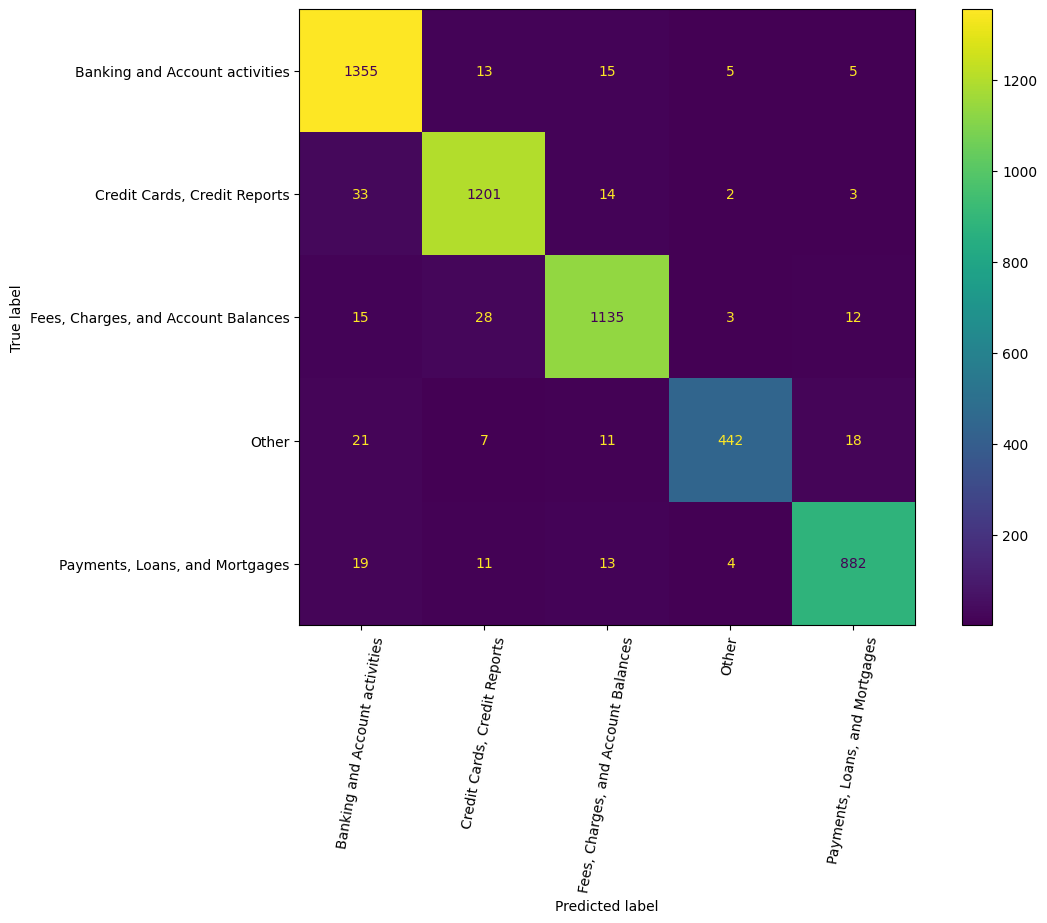

In [120]:
# Logistic Regression Classification
log_reg = LogisticRegression(random_state=40,solver='liblinear')
# fit model
log_reg.fit(X_train,y_train)
# display classification report
metric2=[]
display_classification_report(log_reg,metric2)